In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy.stats import gamma

# forcing nano scale
from matplotlib.ticker import ScalarFormatter
nano_formatter = ScalarFormatter(useMathText=True)
nano_formatter.set_powerlimits((-9, -9))  # Force e-9

from tqdm import tqdm

def nano(num):
    return num * 10**(-9)

# Direct Ground Truths (No Noise)

### 2d simulation functions

In [2]:
def stokes_einstein(r, t, T_Kelvin, eta):
    # Boltzmann's constant
    k_B = 1.38e-23

    # Calculate diffusion coefficient using Stokes-Einstein relation
    D = (k_B * T_Kelvin) / (6 * np.pi * eta * r)
    
    return D

def no_noise_simulation(radii, num_frames, t=0.1, T_Kelvin=296.55, eta=9.2e-4):
    
    # generate diffusion coefficients
    Ds = stokes_einstein(radii, t, T_Kelvin, eta)
    # calculate sigmas
    variance = 2 * Ds * t
    sigmas = np.sqrt(variance)
    
    # create initial positions
    positions = np.zeros((num_frames, num_particles, 2))
    # have all particles start at origin for now
    
    
    # do wiener step process
    for frame in range(1, num_frames):
        # from previous group:
        move = np.column_stack((np.random.normal(0, sigmas, num_particles), 
                                     np.random.normal(0, sigmas, num_particles)))
        positions[frame] = positions[frame - 1] + move

    return positions


### Monte Carlo test

No multi-threading, just sample a lot of radii

In [3]:
num_particles = 100000
radii = np.random.normal(nano(100), nano(20), num_particles)


# from test data
num_frames = 138
t = 0.1 #100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4

# generate simulated positions
sim_positions = no_noise_simulation(radii, num_frames, t, T_Kelvin, eta)


# calculate exact priors
# calculate C
k_B = 1.38e-23
C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)


# use radii to calculate list of precisions
tau_s = radii / C

# fit gamma distribution to the precisions list
# this will be used as our overall tau prior
shape, loc, scale = stats.gamma.fit(tau_s, floc=0)

prior_alpha = shape
prior_beta = 1 / scale



percentages = []
variances = []

# go through all particles
# run through inference for each particle
for i in tqdm(range(num_particles)):
    # get x and y positions
    x_pos = sim_positions[:, i, 0]
    y_pos = sim_positions[:, i, 1]

    # calculate movement by differences between positions
    x_dist = np.diff(x_pos)
    y_dist = np.diff(y_pos)

    # square all the distance movements
    x_dist_sqd = np.square(x_dist)
    y_dist_sqd = np.square(y_dist)

    # concatenate distances into one array
    dist_sqd_array = np.concatenate((x_dist_sqd, y_dist_sqd))
    
    # calculate posterior alpha and beta
    num_dists = len(dist_sqd_array)
    posterior_alpha = prior_alpha + (num_dists / 2)
    
    posterior_beta = (prior_beta + (sum(dist_sqd_array) / 2)) / C
    
    
    # get true radius
    true_radius = radii[i]

    # calculate cdp of true radius
    p_true_radius = gamma.cdf(true_radius, a=posterior_alpha, scale= 1 / posterior_beta)

    # append to percentages
    percentages.append(p_true_radius)

    # append to variances
    variances.append(gamma.var(a=posterior_alpha, scale= 1 / posterior_beta))

percentages = np.array(percentages)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:16<00:00, 6219.03it/s]


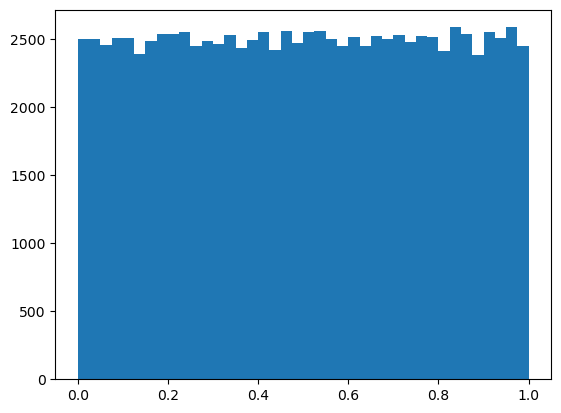

In [4]:
plt.hist(percentages, bins=40) #2.5% bins
plt.show()

In [5]:
np.mean((percentages >= 0.025) & (percentages <= 0.975))

np.float64(0.95047)

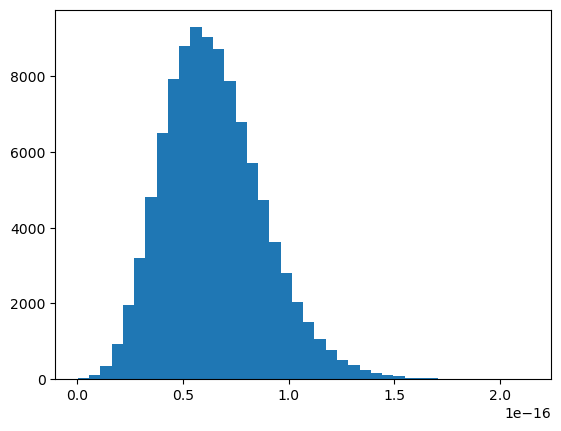

In [6]:
plt.hist(variances, bins=40)
plt.show()

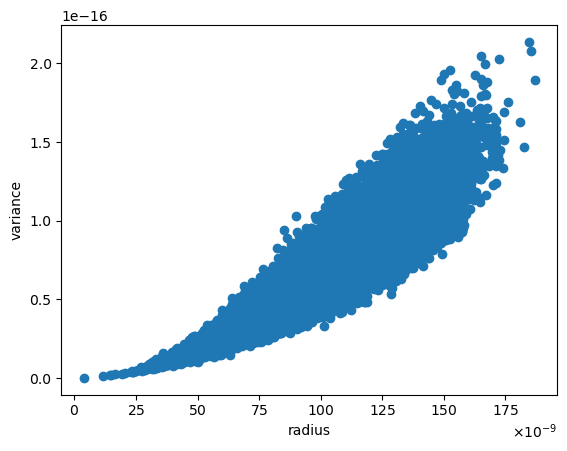

In [7]:
plt.scatter(radii, variances)
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("radius")
plt.ylabel("variance")
plt.show()

$$ $$

$$ $$

$$ $$

$$ $$

# Some Noise with Ground Truths

Run no noise simulation and add noise to generated positions

### Monte Carlo test

No multi-threading, just do a lot of particles

In [8]:
noise_mu = nano(100)
noise_sigma = nano(100)

num_particles = 100000
radii = np.random.normal(nano(100), nano(20), num_particles)

# from test data
num_frames = 138
t = 0.1 #100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4

# generate simulated positions
sim_positions = no_noise_simulation(radii, num_frames, t, T_Kelvin, eta)


# add guassian noise to positions
noisy_positions = sim_positions + np.random.normal(loc=noise_mu, scale=noise_sigma, size=sim_positions.shape)


# calculate exact priors
# calculate C
k_B = 1.38e-23
C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)


# use radii to calculate list of precisions
tau_s = radii / C

# fit gamma distribution to the precisions list
# this will be used as our overall tau prior
shape, loc, scale = stats.gamma.fit(tau_s, floc=0)

prior_alpha = shape
prior_beta = 1 / scale



percentages = []
variances = []

# go through all particles
# run through inference for each particle
for i in tqdm(range(num_particles)):
    # get x and y positions
    x_pos = noisy_positions[:, i, 0]
    y_pos = noisy_positions[:, i, 1]

    # calculate movement by differences between positions
    x_dist = np.diff(x_pos)
    y_dist = np.diff(y_pos)

    # square all the distance movements
    x_dist_sqd = np.square(x_dist)
    y_dist_sqd = np.square(y_dist)

    # concatenate distances into one array
    dist_sqd_array = np.concatenate((x_dist_sqd, y_dist_sqd))
    
    # calculate posterior alpha and beta
    num_dists = len(dist_sqd_array)
    posterior_alpha = prior_alpha + (num_dists / 2)
    
    posterior_beta = (prior_beta + (sum(dist_sqd_array) / 2)) / C
    
    
    # get true radius
    true_radius = radii[i]

    # calculate cdp of true radius
    p_true_radius = gamma.cdf(true_radius, a=posterior_alpha, scale= 1 / posterior_beta)
    
    # append to percentages
    percentages.append(p_true_radius)

    # append to variances
    variances.append(gamma.var(a=posterior_alpha, scale= 1 / posterior_beta))

percentages = np.array(percentages)

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:16<00:00, 6171.05it/s]


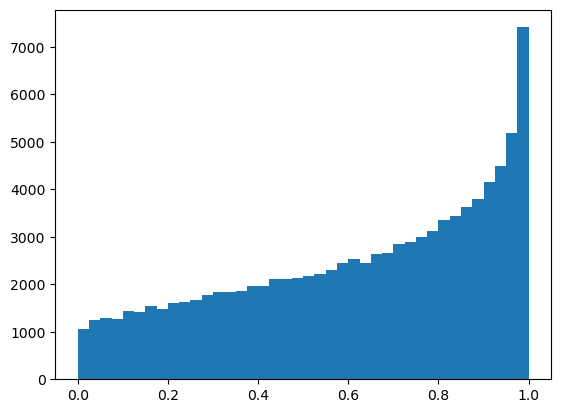

In [9]:
plt.hist(percentages, bins=40) #2.5% bins
plt.show()

In [10]:
np.mean((percentages >= 0.025) & (percentages <= 0.975))

np.float64(0.91532)

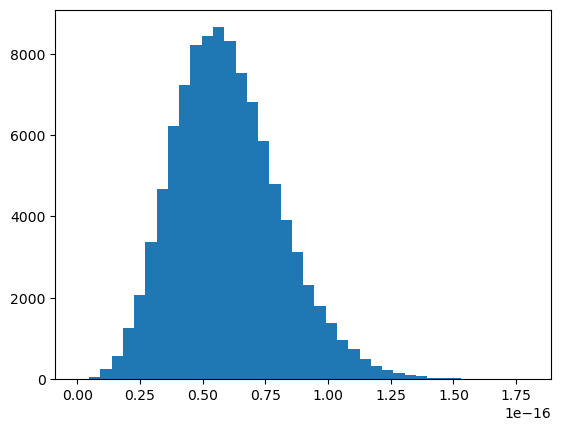

In [11]:
plt.hist(variances, bins=40)
plt.show()

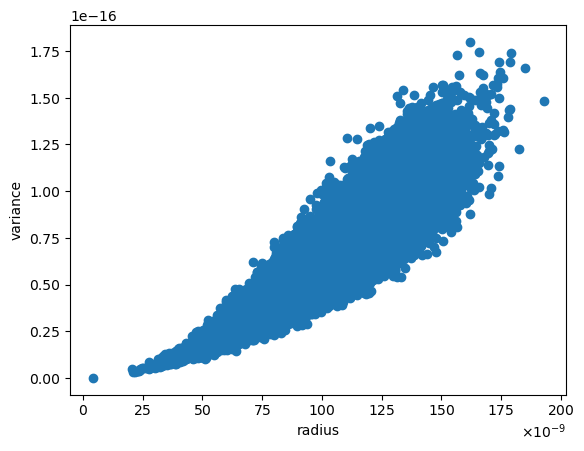

In [12]:
plt.scatter(radii, variances)
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("radius")
plt.ylabel("variance")
plt.show()

$$ $$

$$ $$

$$ $$

$$ $$

# Noise Variance vs Coverages

Use multithreading (one job per variance level)

In [13]:
import multiprocessing
from multiprocessing import Pool
import noise_test_helper

import importlib
#importlib.reload(noise_test_helper)

### Call multithreading

Let all of them use the same original positions array

In [19]:
confidences = [90, 95, 99]

# choose range of standard deviations to test
num_sigmas = 250
noise_sigmas = np.linspace(nano(0.1), nano(300), num_sigmas)
noise_mu = 0



# make simulation positions to use
num_particles = 10000
radii = np.random.normal(nano(100), nano(20), num_particles)

# from test data
num_frames = 138
t = 0.1 #100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4

# generate simulated positions
sim_positions = no_noise_simulation(radii, num_frames, t, T_Kelvin, eta)



# calculate exact priors
# calculate C
k_B = 1.38e-23
C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)


# use radii to calculate list of precisions
tau_s = radii / C

# fit gamma distribution to the precisions list
# this will be used as our overall tau prior
shape, loc, scale = stats.gamma.fit(tau_s, floc=0)

prior_alpha = shape
prior_beta = 1 / scale



population = []
for i in range(num_sigmas):
    current = {"positions" : sim_positions, 
               "confidences"   : confidences, 
               "noise_mu"      : noise_mu, 
               "noise_sigma"   : noise_sigmas[i], 
               "num_particles" : num_particles,
               "prior_alpha"   : prior_alpha,
               "prior_beta"    : prior_beta,
               "radii"         : radii,
               "C"             : C}
    population.append(current)


if __name__ == '__main__':
    pool = Pool()
    batch_results = pool.map(noise_test_helper.run_noise_test, population)

In [20]:
coverage_90 = [r[90] for r in batch_results]
coverage_95 = [r[95] for r in batch_results]
coverage_99 = [r[99] for r in batch_results]

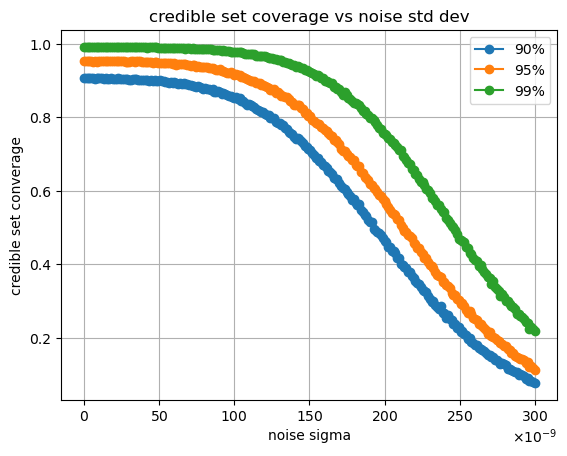

In [21]:
plt.plot(noise_sigmas, coverage_90, marker='o', label="90%")
plt.plot(noise_sigmas, coverage_95, marker='o', label="95%")
plt.plot(noise_sigmas, coverage_99, marker='o', label="99%")
plt.legend()
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel('noise sigma')
plt.ylabel('credible set converage')
plt.title('credible set coverage vs noise std dev')
plt.grid(True)
plt.show()

In [22]:
mean_variances = [r["mean_variance"] for r in batch_results]

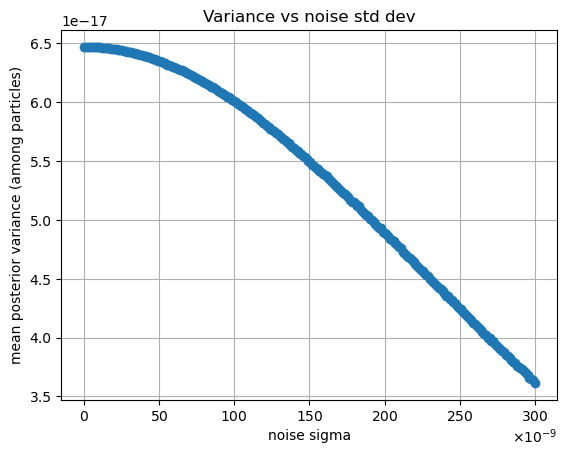

In [23]:
plt.plot(noise_sigmas, mean_variances, marker='o')
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel('noise sigma')
plt.ylabel('mean posterior variance (among particles)')
plt.title('Variance vs noise std dev')
plt.grid(True)
plt.show()